<h2>Speech Emotion Recognition Using CNN Model</h2>

<p><b> Filename Identifiers </b>
<br>
<b>Modality : </b> (01 = full-AV, 02 = video-only, 03 = audio-only).
<br>
<b>Vocal channel : </b> (01 = speech, 02 = song).
<br>
<b>Emotion : </b> (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
<br>
<b>Emotional intensity : </b> (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
<br>
<b>Statement : </b> (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
<br>
<b>Repetition : </b> (01 = 1st repetition, 02 = 2nd repetition).
<br>
<b>Actor : </b> (01 to 24. Odd numbered actors are male, even numbered genders are female).</p>

In [138]:
# 引入库
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd  
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # 用于播放音频
import os 
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
import numpy as np
from sklearn.dummy import DummyClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

Display Random Dataset

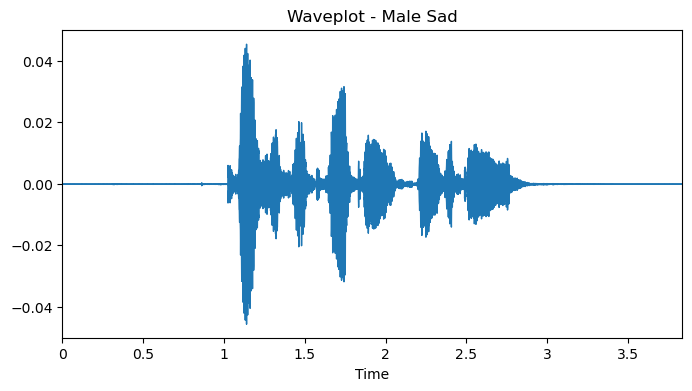

In [2]:
x, sample_rate = librosa.load('dataset/Actor_01/03-01-04-01-01-01-01.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x,sample_rate)
plt.title('Waveplot - Male Sad')
plt.savefig('image/Waveplot_MaleSad.png')
librosa.output.write_wav('saved_wav/Male_Sad.wav', x, sample_rate)
Audio(data=x,rate=sample_rate)  # 播放音频

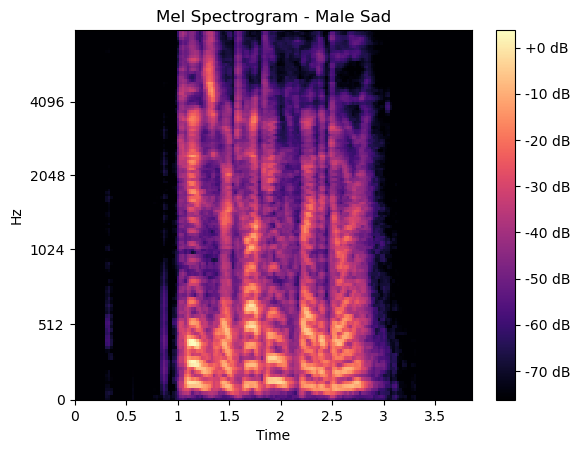

In [3]:
# 创建 log 梅尔声谱图 (LOG MEL SPECTROGRAM)
# fmax 用于设置梅尔频率标度
spectrogram = librosa.feature.melspectrogram(x, sample_rate, n_mels=128, fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Sad')
plt.savefig('image/MelSpec_MaleSad.png')
plt.colorbar(format='%+2.0f dB')

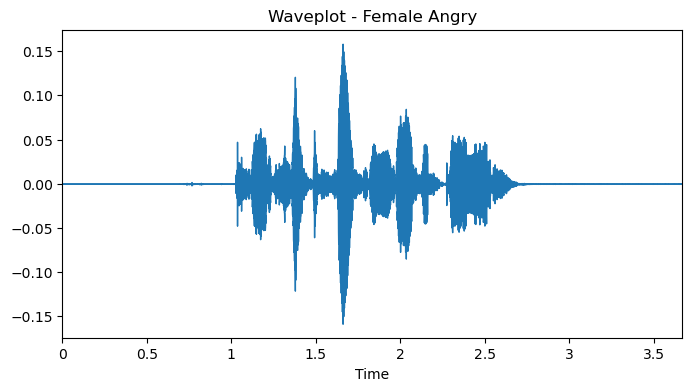

In [4]:
x, sample_rate = librosa.load('dataset/Actor_02/03-01-05-01-01-01-02.wav')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x,sample_rate)
plt.title('Waveplot - Female Angry')
plt.savefig('image/Waveplot_FemaleAngry.png')
librosa.output.write_wav('saved_wav/Female_Angry.wav', x, sample_rate)
Audio(data=x,rate=sample_rate)  # 播放音频

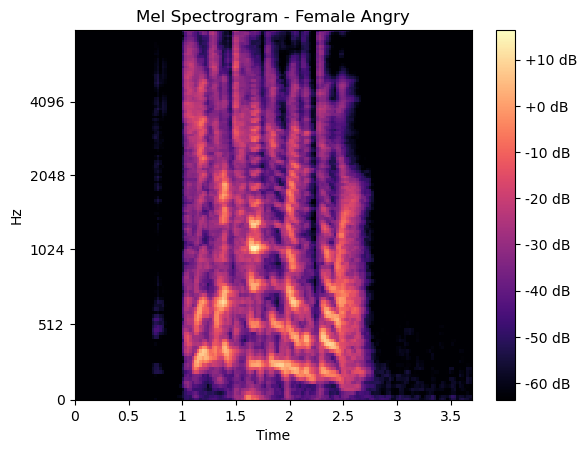

In [5]:
# 创建 log 梅尔声谱图 (LOG MEL SPECTROGRAM)
# fmax 用于设置梅尔频率标度
spectrogram = librosa.feature.melspectrogram(x, sample_rate, n_mels=128, fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Female Angry')
plt.savefig('image/MelSpec_FemaleAngry.png')
plt.colorbar(format='%+2.0f dB')

<h5>Preprocess Data 数据预处理</h5>

In [6]:
audio = "dataset/"
actor_folders = os.listdir(audio) #列出音频目录中的文件
actor_folders.sort() 

In [56]:
# 提取情感编号、演员和性别标签
def get_data(actor_folders):
    emotion,gender,actor,file_path = [],[],[],[]
    for i in actor_folders:
        filename = os.listdir(audio + i)  # iterate over Actor folders
        for f in filename:  # go through files in Actor folder
            part = f.split('.')[0].split('-')
            if not len(part) == 7:
                continue
            emotion.append(int(part[2]))
            actor.append(int(part[6]))
            bg = int(part[6])
            if bg%2 == 0:
                bg = "female"
            else:
                bg = "male"
            gender.append(bg)
            file_path.append(audio + i + '/' + f)
    return emotion,gender,actor,file_path

In [116]:

emotion,gender,actor,file_path = get_data(actor_folders)
emotion_df = pd.DataFrame(emotion)
emotion_df = emotion_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
data_df = pd.concat([pd.DataFrame(actor),pd.DataFrame(gender),emotion_df,pd.DataFrame(file_path)],axis=1)
data_df.columns = ['actor','gender','emotion','file_path']
data_df.to_csv('saved_csv/audio.csv')
data_df

,actor,gender,emotion,file_path
0,1,male,neutral,dataset/Actor_01/03-01-01-01-01-01-01.wav
1,1,male,neutral,dataset/Actor_01/03-01-01-01-01-02-01.wav
2,1,male,neutral,dataset/Actor_01/03-01-01-01-02-01-01.wav
3,1,male,neutral,dataset/Actor_01/03-01-01-01-02-02-01.wav
4,1,male,calm,dataset/Actor_01/03-01-02-01-01-01-01.wav
...,...,...,...,...
1435,24,female,surprise,dataset/Actor_24/03-01-08-01-02-02-24.wav
1436,24,female,surprise,dataset/Actor_24/03-01-08-02-01-01-24.wav
1437,24,female,surprise,dataset/Actor_24/03-01-08-02-01-02-24.wav
1438,24,female,surprise,dataset/Actor_24/03-01-08-02-02-01-24.wav


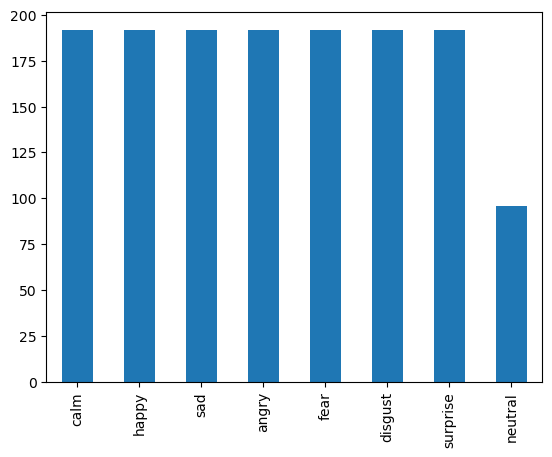

In [117]:
# 类分布
data_df.emotion.value_counts().plot(kind='bar')

In [118]:
data_df['emotion'].unique()

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust',
       'surprise'], dtype=object)

<h5>Feature Extraction 特征提取</h5>

In [119]:
# 遍历所有音频文件并将 LOG 梅尔声谱图频谱图的平均值提取到 DF 中以进行建模
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(data_df.file_path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    # 获取梅尔标度的频谱图（将y轴（频率）转换为对数刻度，将“颜色”轴（振幅）转换为分贝，这是振幅的对数刻度。）
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)  # 时间平均频谱图
    df.loc[counter] = [log_spectrogram]
    counter=counter+1  
print(len(df))
df.head()

1440


,mel_spectrogram
0,"[-76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.38517, -76.36786, -76.37246, -76.38517, -76.38517, -76.17431, -75.719505, -75.94193, -75.64302, -75.90935, -75.831375, -75.751114, -74.78015, -72.83191, -71.263756, -66.52322, -66.22395, -70.02076, -72.22921, -72.31408, -73.10347, -73.701065, -74.247696, -72.630394, -70.08893, -71.00703, -71.96019, -64.493034, -45.90911, -40.03265, -41.116196, -43.53594, -40.619087, -35.054295, -32.517746, -32.09286, -32.518032, -33.537327, -33.267906, -35.378788, -40.179214, -42.37324, -43.332733, -42.33963, -40.890015, -37.123814, -35.46733, -33.28553, -32.946808, -32.99233, -33.490063, -35.9455, -41.89657, -47.815556, -50.32335, -45.50298, -38.28953, -38.66705, -41.103416, -41.81687, -42.414722, -41.487434, -39.02261, -35.519184, -33.715645, -33.54078, -34.01719, -34.092537, -32.43697, -31.850922, -33.650414, -38.193787, -42.978214, -45.402687, -45.206203, -44.58686, -45.937107, -45.795887, -40.709045, -37.873074, -38.022858, -38.16431, -39.509552, -41.684135, -42.942142, ...]"
1,"[-75.33588, -75.44567, -75.554375, -75.20429, -75.23087, -75.31972, -75.65414, -75.720375, -75.720375, -75.720375, -75.720375, -75.720375, -75.55636, -75.1184, -75.0596, -75.37099, -75.391594, -75.65218, -75.720375, -75.720375, -75.54746, -75.301704, -75.144135, -75.150276, -75.40712, -72.98939, -65.36437, -66.21635, -71.88308, -61.77353, -55.71276, -54.201763, -59.008724, -65.38103, -71.74732, -73.44525, -74.10868, -75.11392, -75.422935, -73.35708, -71.12269, -71.67145, -72.885124, -57.992264, -46.606167, -42.765457, -42.77682, -44.442326, -43.676636, -39.067356, -35.260796, -33.520035, -32.133297, -31.929964, -32.559666, -35.611877, -41.081226, -44.21871, -45.059032, -44.434967, -43.620308, -41.230057, -38.099014, -35.112717, -33.440674, -33.15926, -33.61405, -33.65351, -33.701817, -36.430912, -42.56046, -47.216526, -50.08694, -51.846832, -41.40661, -36.932133, -37.993782, -39.502655, -40.629604, -38.977577, -37.318096, -38.026085, -36.580303, -32.02303, -30.128885, -30.4522, -30.167248, -29.611923, -31.49946, -37.14612, -43.22088, -46.133022, -44.403244, -42.880116, -44.656788, -46.631077, -43.144547, -40.014847, -38.66243, -37.18039, ...]"
2,"[-75.15079, -75.15079, -75.15079, -75.15079, -75.15079, -75.15079, -75.15079, -75.13967, -75.07232, -75.15079, -75.15079, -75.15079, -75.15079, -75.09946, -75.15079, -75.15079, -75.15079, -75.10913, -75.0942, -75.15079, -74.92831, -74.15182, -74.19854, -74.5156, -75.11962, -75.10407, -75.13173, -75.15079, -75.15079, -75.149956, -75.15079, -75.15079, -75.15079, -75.15079, -75.15079, -75.069115, -74.12111, -73.6178, -74.536125, -74.174065, -73.56252, -72.485245, -73.08493, -49.680977, -39.80165, -36.83088, -35.704613, -34.180252, -31.863138, -30.693201, -30.325672, -30.965347, -30.824116, -30.033842, -28.690817, -28.169178, -28.13898, -29.082067, -30.787987, -32.99949, -37.513935, -41.93026, -44.938816, -44.383423, -41.121216, -40.154804, -39.989162, -39.93824, -41.253056, -40.453785, -37.339134, -35.710888, -36.269848, -36.071182, -36.352654, -36.93645, -38.03055, -39.899998, -40.52588, -41.243824, -41.38294, -40.334106, -38.54372, -39.558132, -40.66751, -37.1995, -32.581936, -32.73879, -33.55274, -37.30237, -43.40366, -39.87777, -35.74474, -34.765434, -34.003635, -33.998913, -34.424145, -35.47756, -38.35185, -41.040623, ...]"
3,"[-75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.24309, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.24536, -75.04578, -74.99178, -75.19998, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -75.268524, -74.34868, -73.92553, -73.563644, -73.27902, -72.94665, -72.36577, -72.77179, -62.660824, -41.765606

In [120]:
data_df = pd.concat([data_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
data_df = data_df.fillna(0)
data_df.head()

,actor,gender,emotion,file_path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,1,male,neutral,dataset/Actor_01/03-01-01-01-01-01-01.wav,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,male,neutral,dataset/Actor_01/03-01-01-01-01-02-01.wav,-75.335876,-75.445671,-75.554375,-75.204292,-75.230873,-75.319717,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,male,neutral,dataset/Actor_01/03-01-01-01-02-01-01.wav,-75.150787,-75.150787,-75.150787,-75.150787,-75.150787,-75.150787,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,male,neutral,dataset/Actor_01/03-01-01-01-02-02-01.wav,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,male,calm,dataset/Actor_01/03-01-02-01-01-01-01.wav,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,...,-80.147774,-80.147774,-80.122353,-79.998413,-80.119652,-80.147774,-80.130814,-80.015106,-80.147774,-80.147774


In [121]:
data_df.drop(columns='file_path',inplace=True)
data_df.drop(columns='actor',inplace=True)
data_df.head()

,gender,emotion,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,-76.385170,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,-75.335876,-75.445671,-75.554375,-75.204292,-75.230873,-75.319717,-75.654137,-75.720375,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,-75.150787,-75.150787,-75.150787,-75.150787,-75.150787,-75.150787,-75.150787,-75.139671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,-75.268524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,-80.147774,...,-80.147774,-80.147774,-80.122353,-79.998413,-80.119652,-80.147774,-80.130814,-80.015106,-80.147774,-80.147774


In [140]:
train_data, test_data = train_test_split(data_df, 
                                        test_size=0.2, 
                                        stratify=data_df[['emotion','gender']])
def get_model_data(data):
    X = data.iloc[:, 3:]
    y = data.iloc[:,:2].drop(columns=['gender'])
    print(X.shape,y.shape)
    return X,y

In [141]:
X_train, y_train = get_model_data(train_data)
X_test, y_test = get_model_data(test_data)

(1152, 258) (1152, 1)
(288, 258) (288, 1)


In [142]:
# 标准化数据
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = np.array((X_train - mean)/std)
X_test = np.array((X_test - mean)/std)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [143]:
print(y_test[0:10])

[['disgust']
 ['surprise']
 ['disgust']
 ['calm']
 ['happy']
 ['neutral']
 ['surprise']
 ['angry']
 ['surprise']
 ['disgust']]


In [144]:
# One Hot Encoder 标签
# CNN 要求输入和输出都是数字
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
print(y_test.shape)
print(y_test[0:10])

(288, 8)
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [145]:
print(X_train.shape, X_test.shape)
X_train_3D = X_train[:,:,np.newaxis]
X_test_3D = X_test[:,:,np.newaxis]
print(X_train_3D.shape, X_test_3D.shape)

(1152, 258) (288, 258)
(1152, 258, 1) (288, 258, 1)


<h5> CNN Model</h5>

In [183]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

# 构建一维 CNN 层
def CNN_Model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model

In [202]:
model = CNN_Model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 249, 64)           704       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 240, 128)          82048     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 2, 128)           

In [203]:
history = model.fit(  X_train_3D, 
            y_train,
            batch_size=16, 
            epochs=100, 
            validation_data=(X_test_3D, y_test))



Epoch 1/100
72/72 [==============================] - 2s 32ms/step - loss: 2.2562 - accuracy: 0.2057 - val_loss: 1.9209 - val_accuracy: 0.2917
Epoch 2/100
72/72 [==============================] - 2s 31ms/step - loss: 1.8762 - accuracy: 0.2526 - val_loss: 1.8131 - val_accuracy: 0.2500
Epoch 3/100
72/72 [==============================] - 2s 30ms/step - loss: 1.8268 - accuracy: 0.2786 - val_loss: 1.7226 - val_accuracy: 0.3229
Epoch 4/100
72/72 [==============================] - 2s 30ms/step - loss: 1.7787 - accuracy: 0.2943 - val_loss: 1.6985 - val_accuracy: 0.3333
Epoch 5/100
72/72 [==============================] - 2s 29ms/step - loss: 1.7532 - accuracy: 0.3186 - val_loss: 1.6980 - val_accuracy: 0.3681
Epoch 6/100
72/72 [==============================] - 2s 30ms/step - loss: 1.7062 - accuracy: 0.3342 - val_loss: 1.6622 - val_accuracy: 0.3681
Epoch 7/100
72/72 [==============================] - 2s 30ms/step - loss: 1.6876 - accuracy: 0.3385 - val_loss: 1.6323 - val_accuracy: 0.3958
Epoch 

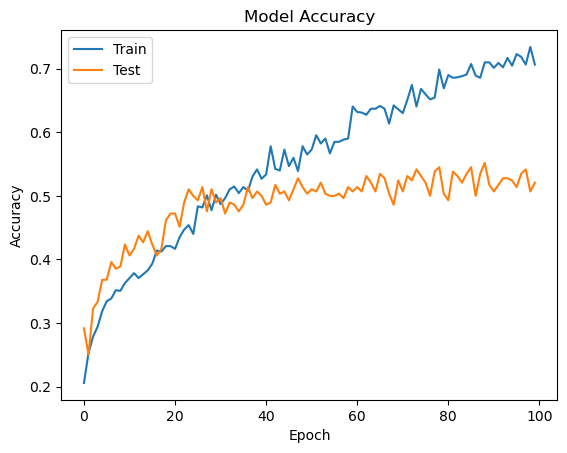

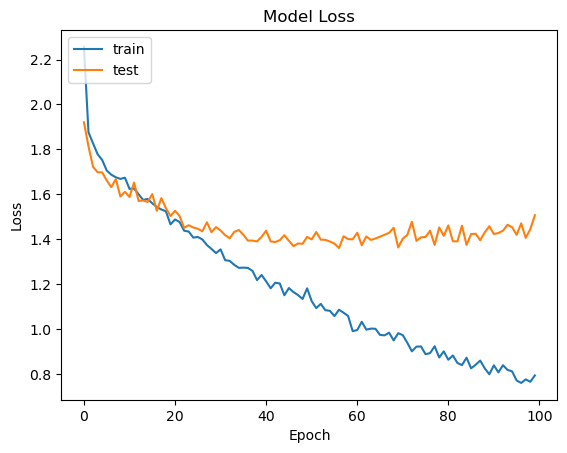

In [204]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('image/accuracy_plot.png')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('image/loss_plot.png')
plt.show()

<h5>Evaluate Model Performance 评估模型性能</h5>

In [205]:
print('Evalute Model Performance')
print("Loss : " , model.evaluate(X_test_3D,y_test)[0])
print("Accuracy : " , round(model.evaluate(X_test_3D,y_test)[1]*100,2) , "%")

Evalute Model Performance
9/9 [==============================] - 0s 12ms/step - loss: 1.5074 - accuracy: 0.5208
Loss :  1.5073692798614502
9/9 [==============================] - 0s 12ms/step - loss: 1.5074 - accuracy: 0.5208
Accuracy :  52.08 %


In [206]:
# 预测标签
predictions = model.predict(X_test_3D).argmax(axis=1).astype(int).flatten()
predictions = (label_encoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# 真实标签
actual = y_test.argmax(axis=1).astype(int).flatten()
actual = (label_encoder.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

combinedf = actual.join(predictions)
combinedf.head(10)

,Actual Values,Predicted Values
0,disgust,disgust
1,surprise,surprise
2,disgust,disgust
3,calm,calm
4,happy,happy
5,neutral,sad
6,surprise,surprise
7,angry,angry
8,surprise,surprise
9,disgust,disgust


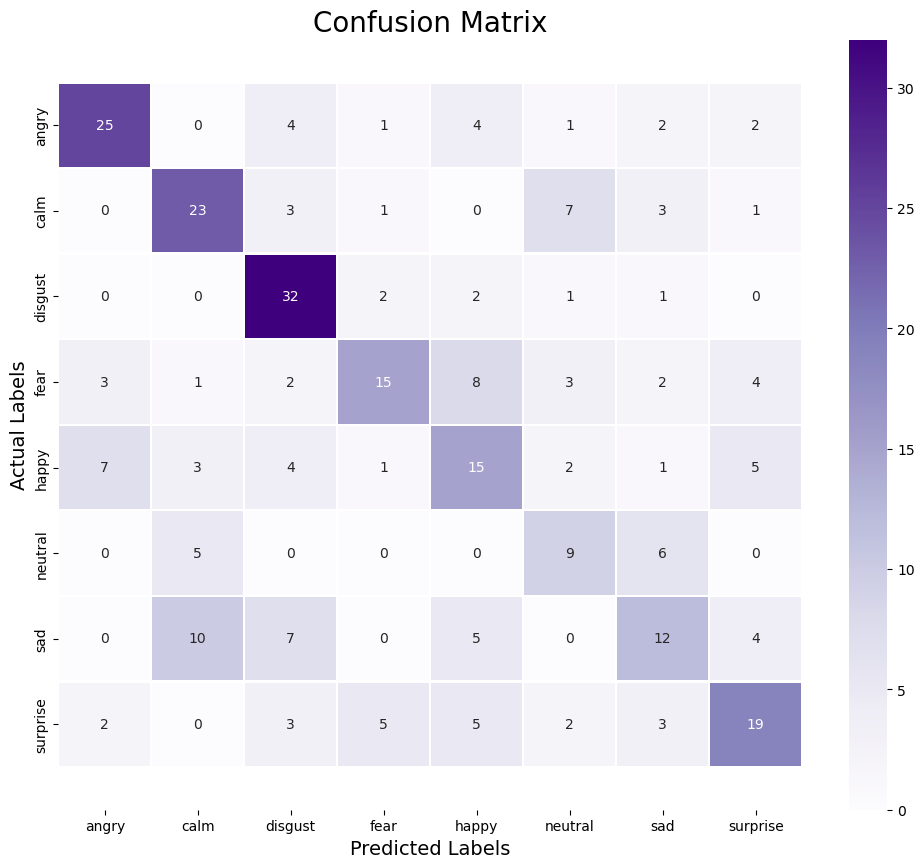

In [207]:
# Confusion Matrix
conf_mat = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
conf_mat = pd.DataFrame(conf_mat , 
                        index = [i for i in label_encoder.classes_] , 
                        columns = [i for i in label_encoder.classes_])
ax = sns.heatmap(conf_mat, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('image/Confusion-Matrix.png')
plt.show()

In [208]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.68      0.64      0.66        39
        calm       0.55      0.61      0.57        38
     disgust       0.58      0.84      0.69        38
        fear       0.60      0.39      0.48        38
       happy       0.38      0.39      0.39        38
     neutral       0.36      0.45      0.40        20
         sad       0.40      0.32      0.35        38
    surprise       0.54      0.49      0.51        39

    accuracy                           0.52       288
   macro avg       0.51      0.52      0.51       288
weighted avg       0.52      0.52      0.51       288

